<h1><center>High Traffic Clustering</center></h1>

Bu notebook, high ve non-high trafik noktalarının belirlenmesi için İstanbul özelinde Traditional channel'da 2'li hierarchical clustering çalışması içerir.


In [1]:
# Database Connection
from google.cloud import bigquery, bigquery_storage_v1beta1

# Basic
import os
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import datetime as dt

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Model
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.svm import SVC
from scipy.special import boxcox1p
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, Birch, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix

sns.set_style("whitegrid")
# sns.color_palette('bright')
sns.set_palette('dark')

In [2]:
xls = pd.ExcelFile('traffic_high_low.xlsx')
df_high = pd.read_excel(xls, 'High Traffic')
df_non = pd.read_excel(xls, 'Non-high Traffic')
all_data = pd.read_excel(xls, 'all_data')

In [3]:
all_data.head()

,outlet_number,outlet_name,high_traffic
0,9422535,Şampiyon Tekel & Gıda,0
1,9109019,Flamingo Tekel,0
2,9489908,Fıçı Tekel,0
3,3008089,Yerlisu Gıda,0
4,9566010,Kupa Tekel,0


In [4]:
df_new = pd.read_csv('shopper_data.csv')

In [5]:
df_new = df_new.fillna(0)

In [6]:
len(df_new)

304608

In [7]:
df_new.head()

,outlet_number,outlet_name,GEOGPOINT,IDARIID,MAIN_CHANNEL,SES,YAS_CLUSTER,ILADI,ILCEADI,HANE_BUYUKLUGU,...,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,7173090,DAVUT BIRLES,POINT(29.06531874 40.1851168),22528,ON-PREMISE,C1,SIFIR,Bursa,Osmangazi,0.663415,...,0.0,0.000,0.000,0.0,4.225,0.000,0.0,0.0,0.000,0.00
1,7158909,DOGAN TEKEL,POINT(29.06616217 40.18558327),22528,TRADITIONAL RETAIL,C1,SIFIR,Bursa,Osmangazi,0.663415,...,0.0,0.000,0.000,0.0,70.906,33.571,0.0,0.0,8.452,0.00
2,9082733,KARDESLER PIDE,POINT(29.06576674 40.18505304),22528,ON-PREMISE,C1,SIFIR,Bursa,Osmangazi,0.663415,...,0.0,49.855,1605.880,0.0,134.430,8.364,0.0,0.0,0.000,42.52
3,9468815,IHLAMURALTI CAY BAHCESI,POINT(29.0648084200769 40.1860698786783),22528,ON-PREMISE,C1,SIFIR,Bursa,Osmangazi,0.663415,...,0.0,0.000,46.486,0.0,5.070,0.000,0.0,0.0,0.000,0.00
4,8921197,PARALI BUFE,POINT(29.0647642900001 40.18573423),22528,ON-PREMISE,C1,SIFIR,Bursa,Osmangazi,0.663415,...,0.0,0.000,88.746,0.0,37.403,2.091,0.0,0.0,0.000,2.79


In [8]:
#Sadece İstanbul genelini aldım.
df_new = df_new.query("ILADI == 'İstanbul'").reset_index(drop=True)

In [9]:
df_new.head()

,outlet_number,outlet_name,GEOGPOINT,IDARIID,MAIN_CHANNEL,SES,YAS_CLUSTER,ILADI,ILCEADI,HANE_BUYUKLUGU,...,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,9663438,YILMAZ BUFE,POINT(28.9709006622433 41.0139870783315),33795,ON-PREMISE,C2,SIFIR,İstanbul,Fatih,2.0,...,0.0,0.000,0.000,1.394,20.754,0.000,0.0,0.0,0.0,0.00
1,9330096,HAVUZLU HAN CAY OCAGIX,POINT(28.97060831 41.01396785),33795,ON-PREMISE,C2,SIFIR,İstanbul,Fatih,2.0,...,0.0,1.690,80.296,0.000,3.380,0.000,0.0,0.0,0.0,1.69
2,10731204,TEMIZ KOFTECISIX,POINT(28.97056176 41.01414036),33795,ON-PREMISE,C2,SIFIR,İstanbul,Fatih,2.0,...,0.0,0.845,29.971,0.000,2.535,0.000,0.0,0.0,0.0,0.00
3,9649660,ERDAL KARCI,POINT(28.9708052761853 41.0131731955335),33795,ON-PREMISE,C2,SIFIR,İstanbul,Fatih,2.0,...,0.0,5.915,454.295,0.000,8.538,4.879,0.0,0.0,0.0,5.03
4,9679730,MERKEZHAN,POINT(28.9720169641078 41.0116889281199),33795,ON-PREMISE,C2,SIFIR,İstanbul,Fatih,2.0,...,0.0,0.000,6.339,0.000,1.690,0.000,0.0,0.0,0.0,0.00


In [10]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52534 entries, 0 to 52533
Data columns (total 71 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   outlet_number                    52534 non-null  int64  
 1   outlet_name                      52534 non-null  object 
 2   GEOGPOINT                        52534 non-null  object 
 3   IDARIID                          52534 non-null  int64  
 4   MAIN_CHANNEL                     52534 non-null  object 
 5   SES                              52534 non-null  object 
 6   YAS_CLUSTER                      52534 non-null  object 
 7   ILADI                            52534 non-null  object 
 8   ILCEADI                          52534 non-null  object 
 9   HANE_BUYUKLUGU                   52534 non-null  float64
 10  GUNDUZ_NUFUS                     52534 non-null  int64  
 11  GECE_NUFUS                       52534 non-null  int64  
 12  ZENGINLIK_INDEKSI 

In [11]:
# data = Class'ları belli olan dataframe
data = pd.merge(all_data[["outlet_number","high_traffic"]], df_new, on='outlet_number', how='left')

In [17]:
# Sadece İstanbul içeren toplam 65 satır var. 25-> nonhigh, 40-> high traffic
ist_data = data.query("ILADI=='İstanbul'").reset_index(drop=True)

In [18]:
ist_data

,outlet_number,high_traffic,outlet_name,GEOGPOINT,IDARIID,MAIN_CHANNEL,SES,YAS_CLUSTER,ILADI,ILCEADI,...,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,9422535,0,SAMPIYON TEKEL,POINT(29.08295795 40.96606672),33849.0,TRADITIONAL RETAIL,A,OLD,İstanbul,Kadıköy,...,0.000,0.845,16.904,0.0,26.544,7.987,2.557,3.171,57.690,18.639
1,9109019,0,FLAMINGO TEKEL,POINT(29.0819544 40.96638027),33849.0,TRADITIONAL RETAIL,A,OLD,İstanbul,Kadıköy,...,0.528,7.605,223.259,0.0,33.642,51.174,10.978,11.627,237.728,19.525
2,9489908,0,FICI TEKEL,POINT(29.0773806720972 40.9648437285796),33849.0,TRADITIONAL RETAIL,A,OLD,İstanbul,Kadıköy,...,0.000,0.000,60.222,0.0,31.086,4.182,0.000,4.228,33.813,21.511
3,3008089,0,YERLISU GIDA,POINT(29.07878532 40.96849167),33837.0,TRADITIONAL RETAIL,A,OLD,İstanbul,Kadıköy,...,0.000,0.000,0.000,0.0,22.717,12.825,0.000,1.057,16.907,14.750
4,9566010,0,KUPA TEKEL,POINT(29.0832091122866 40.9705169778317),33837.0,TRADITIONAL RETAIL,A,OLD,İstanbul,Kadıköy,...,0.000,49.010,589.919,0.0,16.313,24.554,0.750,0.000,23.032,10.819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,20037032,1,ARA TEKEL,POINT(29.0760085545481 40.963296093978),33849.0,TRADITIONAL RETAIL,A,OLD,İstanbul,Kadıköy,...,0.000,31.265,34.337,0.0,8.411,18.085,0.000,0.000,33.814,14.709
61,9438903,1,LEVENT TEKEL,POINT(29.01525403 41.07585202),33488.0,TRADITIONAL RETAIL,A,OLD,İstanbul,Beşiktaş,...,6.336,0.000,0.697,0.0,92.184,27.119,40.846,2.114,187.001,28.312
62,9476662,1,HISAR TEKEL,POINT(29.04673418 41.08544032),34014.0,TRADITIONAL RETAIL,A,MIDDLE AGED,İstanbul,Sarıyer,...,0.000,2.535,135.419,0.0,86.538,26.279,7.978,14.798,277.868,96.693
63,9477702,1,DERIN KURUYEMIS,POINT(28.99466178 41.06785797),34142.0,TRADITIONAL RETAIL,A,MIDDLE AGED,İstanbul,Şişli,...,2.112,5.070,147.871,0.0,63.483,78.816,37.333,10.570,26.415,20.371


In [19]:
# real values vs preds. bakılırken bu datayı kullanacaksın.
ist_data.MAIN_CHANNEL.unique()

array(['TRADITIONAL RETAIL'], dtype=object)

### Data Prep.

In [20]:
prep_data = df_new.copy()

In [21]:
prep_data.MAIN_CHANNEL.unique()

array(['ON-PREMISE', 'TRADITIONAL RETAIL', 'MODERN RETAIL', 'E-COMMERCE',
       'OTHER/THIRD PARTY', 'DISCOUNTER'], dtype=object)

In [22]:
# sadece traditional olanları al.
prep_data = prep_data.query("MAIN_CHANNEL=='TRADITIONAL RETAIL'").reset_index(drop=True)

In [23]:
model_data = prep_data.copy()

In [24]:
len(model_data)

24711

In [25]:
model_data.head()

,outlet_number,outlet_name,GEOGPOINT,IDARIID,MAIN_CHANNEL,SES,YAS_CLUSTER,ILADI,ILCEADI,HANE_BUYUKLUGU,...,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,9533320,CICEK TEKEL,POINT(28.96875466 41.0172719600001),33796,TRADITIONAL RETAIL,C1,SIFIR,İstanbul,Fatih,1.363636,...,0.528,23.660,78.710,0.0,146.406,39.050,0.000,0.000,102.482,30.260
1,9653108,SEVENLER MARKET,POINT(28.9624869078397 41.020159595646),33799,TRADITIONAL RETAIL,D,SIFIR,İstanbul,Fatih,1.195455,...,0.000,20.280,29.231,0.0,120.178,31.249,15.956,4.228,2.113,41.863
2,9333727,HAKKI INCESU GAZETE BAYII,POINT(28.9637708 41.01996087),33799,TRADITIONAL RETAIL,D,SIFIR,İstanbul,Fatih,1.195455,...,0.000,22.815,302.225,0.0,47.083,50.333,46.811,1.057,13.529,15.513
3,10729828,BIZIM BAKKAL,POINT(28.96242579 41.02022647),33799,TRADITIONAL RETAIL,D,SIFIR,İstanbul,Fatih,1.195455,...,0.000,0.000,14.791,0.0,331.887,28.372,0.000,17.969,14.580,23.181
4,8941233,OYLUM TEKEL,POINT(28.9609833900001 41.02061902),33799,TRADITIONAL RETAIL,D,SIFIR,İstanbul,Fatih,1.195455,...,0.000,0.000,10.565,0.0,15.320,0.000,0.000,0.000,0.000,0.845


In [26]:
model_data["SES"].unique()

array(['C1', 'D', 'B', 'C2', 'A', 'E'], dtype=object)

#### Label Encoding

In [27]:
model_data["SES"] = model_data["SES"].replace({'A': 6, 'B': 5, 'C1': 4, 'C2': 3, 'D': 2, 'E': 1})

#### İçeceklerin Oranları

In [28]:
brand_list = ["BURN"
             ,"CAPPY"
             ,"CC_LIGHT"
             ,"CC_NO_SUGER"
             ,"COCACOLA"
             ,"COCACOLA_ENERGY"
             ,"DAMLA_MINERA"
             ,"DAMLA_WATER"
             ,"EXOTIC"
             ,"FANTA"
             ,"FUSETEA"
             ,"MONSTER"
             ,"POWERADE"
             ,"SCHWEPPES"
             ,"SPRITE"]

In [29]:
m = model_data[brand_list]

In [30]:
m['total'] = m.sum(axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
m.head(3)

,BURN,CAPPY,CC_LIGHT,CC_NO_SUGER,COCACOLA,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE,total
0,3.696,133.025,1.585,11.242,470.271,0.528,23.660,78.710,0.0,146.406,39.050,0.000,0.000,102.482,30.260,1040.915
1,4.224,79.531,0.000,12.742,409.990,0.000,20.280,29.231,0.0,120.178,31.249,15.956,4.228,2.113,41.863,771.585
2,31.695,195.427,0.000,40.278,143.562,0.000,22.815,302.225,0.0,47.083,50.333,46.811,1.057,13.529,15.513,910.328


In [32]:
model_data["BURN"] = m["BURN"]/m["total"]
model_data["CAPPY"] = m["CAPPY"]/m["total"]
model_data["CC_LIGHT"] = m["CC_LIGHT"]/m["total"]
model_data["CC_NO_SUGER"] = m["CC_NO_SUGER"]/m["total"]
model_data["COCACOLA"] = m["COCACOLA"]/m["total"]
model_data["COCACOLA_ENERGY"] = m["COCACOLA_ENERGY"]/m["total"]
model_data["DAMLA_MINERA"] = m["DAMLA_MINERA"]/m["total"]
model_data["DAMLA_WATER"] = m["DAMLA_WATER"]/m["total"]
model_data["EXOTIC"] = m["EXOTIC"]/m["total"]
model_data["FANTA"] = m["FANTA"]/m["total"]
model_data["FUSETEA"] = m["FUSETEA"]/m["total"]
model_data["MONSTER"] = m["MONSTER"]/m["total"]
model_data["POWERADE"] = m["POWERADE"]/m["total"]
model_data["SCHWEPPES"] = m["SCHWEPPES"]/m["total"]
model_data["SPRITE"] = m["SPRITE"]/m["total"]

#### Gece Gündüz Oranı

In [33]:
# drop columns for final data for model
model_data = model_data.drop(["outlet_name"                   
                             ,"GEOGPOINT"
                             ,"IDARIID"
                             ,"MAIN_CHANNEL"
                             ,"YAS_CLUSTER"
                             ,"ILADI"
                             ,"ILCEADI"
                             ,"HANE_BUYUKLUGU"
                             ,"ZENGINLIK_INDEKSI"
                             ],axis=1)

In [34]:
model_data['GECE_NUFUS'].replace({0: 0.00001}, inplace=True)
model_data['GUNDUZ_NUFUS'].replace({0: 0.00001}, inplace=True)

In [35]:
model_data.head(3)

,outlet_number,SES,GUNDUZ_NUFUS,GECE_NUFUS,SEHIRLESME_INDEKSI,YAYA_TRAFIGI,AYLIK_HARCAMA,GIDAVEICECEK,ALKOLTUTUN,EGLENCEKULTUR,...,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,9533320,4,0.00001,15.0,9.000134,8.000846,6481,0.0,0.0,0.0,...,0.000507,0.022730,0.075616,0.0,0.140651,0.037515,0.000000,0.000000,0.098454,0.029071
1,9653108,2,0.00001,263.0,8.998689,7.000657,2331,0.0,0.0,0.0,...,0.000000,0.026284,0.037884,0.0,0.155755,0.040500,0.020680,0.005480,0.002739,0.054256
2,9333727,2,0.00001,263.0,8.998689,7.000657,2331,0.0,0.0,0.0,...,0.000000,0.025062,0.331996,0.0,0.051721,0.055291,0.051422,0.001161,0.014862,0.017041


In [36]:
g = model_data[['GUNDUZ_NUFUS','GECE_NUFUS']]

In [37]:
model_data["gündüz_gece_oran"] = g["GUNDUZ_NUFUS"]/g["GECE_NUFUS"]

In [38]:
model_data.head(3)

,outlet_number,SES,GUNDUZ_NUFUS,GECE_NUFUS,SEHIRLESME_INDEKSI,YAYA_TRAFIGI,AYLIK_HARCAMA,GIDAVEICECEK,ALKOLTUTUN,EGLENCEKULTUR,...,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE,gündüz_gece_oran
0,9533320,4,0.00001,15.0,9.000134,8.000846,6481,0.0,0.0,0.0,...,0.022730,0.075616,0.0,0.140651,0.037515,0.000000,0.000000,0.098454,0.029071,6.666667e-07
1,9653108,2,0.00001,263.0,8.998689,7.000657,2331,0.0,0.0,0.0,...,0.026284,0.037884,0.0,0.155755,0.040500,0.020680,0.005480,0.002739,0.054256,3.802281e-08
2,9333727,2,0.00001,263.0,8.998689,7.000657,2331,0.0,0.0,0.0,...,0.025062,0.331996,0.0,0.051721,0.055291,0.051422,0.001161,0.014862,0.017041,3.802281e-08


In [39]:
model_data = model_data.fillna(0)

In [40]:
model_data['SES'] = model_data['SES'].astype(str).astype(int)

In [41]:
model_data.SES.unique()

array([4, 2, 5, 3, 6, 1])

In [42]:
model_data = model_data.drop(["outlet_number"                   
                             ,'GUNDUZ_NUFUS'
                             ,'GECE_NUFUS'],axis=1)

In [43]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24711 entries, 0 to 24710
Data columns (total 60 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SES                              24711 non-null  int64  
 1   SEHIRLESME_INDEKSI               24711 non-null  float64
 2   YAYA_TRAFIGI                     24711 non-null  float64
 3   AYLIK_HARCAMA                    24711 non-null  int64  
 4   GIDAVEICECEK                     24711 non-null  float64
 5   ALKOLTUTUN                       24711 non-null  float64
 6   EGLENCEKULTUR                    24711 non-null  float64
 7   LOKANTAOTEL                      24711 non-null  float64
 8   GIDAVEICECEK_ORAN                24711 non-null  float64
 9   ALKOLTUTUN_ORAN                  24711 non-null  float64
 10  EGLENCEKULTUR_ORAN               24711 non-null  float64
 11  LOKANTAOTEL_ORAN                 24711 non-null  float64
 12  ISYERI_YOGUNLUGU_S

#### Scaling and Normal Dist.

In [44]:
# define a method to scale data, looping thru the columns, and passing a scaler
def scale_data(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    for col in data.columns:
        data[col] = min_max_scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data

In [45]:
def normal_dist(data):
    for col in data.columns:
        data[col] = data[col].apply(lambda x: boxcox1p(x,0.25))
        stats.boxcox(data[col])[0]
    return data

In [46]:
def log_data(data):
    for col in data.columns:
        data[col] = data[col].apply(lambda x: np.log(x))
    return data

In [47]:
copy_data = model_data.copy()

In [48]:
copy_data.head(2)

,SES,SEHIRLESME_INDEKSI,YAYA_TRAFIGI,AYLIK_HARCAMA,GIDAVEICECEK,ALKOLTUTUN,EGLENCEKULTUR,LOKANTAOTEL,GIDAVEICECEK_ORAN,ALKOLTUTUN_ORAN,...,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE,gündüz_gece_oran
0,4,9.000134,8.000846,6481,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022730,0.075616,0.0,0.140651,0.037515,0.00000,0.00000,0.098454,0.029071,6.666667e-07
1,2,8.998689,7.000657,2331,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026284,0.037884,0.0,0.155755,0.040500,0.02068,0.00548,0.002739,0.054256,3.802281e-08


In [49]:
copy_data = copy_data.drop(["IL_BAZLI_TURIST_YERLI_ISLETME","IL_BAZLI_TURIST_YBN_ISLETME"],axis=1)

In [50]:
copy_data[copy_data < 0] = 0

In [51]:
copy_data.replace({0: 0.00001}, inplace=True)

#### Normal Dist. Part 

In [52]:
copy_data["SES"] = stats.boxcox(copy_data["SES"])[0]
copy_data["SEHIRLESME_INDEKSI"] = stats.boxcox(copy_data["SEHIRLESME_INDEKSI"])[0]
copy_data["YAYA_TRAFIGI"] = stats.boxcox(copy_data["YAYA_TRAFIGI"])[0]
copy_data["AYLIK_HARCAMA"] = stats.boxcox(copy_data["AYLIK_HARCAMA"])[0]
copy_data["GIDAVEICECEK"] = stats.boxcox(copy_data["GIDAVEICECEK"])[0]
copy_data["ALKOLTUTUN"] = stats.boxcox(copy_data["ALKOLTUTUN"])[0]
copy_data["EGLENCEKULTUR"] = stats.boxcox(copy_data["EGLENCEKULTUR"])[0]
copy_data["LOKANTAOTEL"] = stats.boxcox(copy_data["LOKANTAOTEL"])[0]
copy_data["GIDAVEICECEK_ORAN"] = stats.boxcox(copy_data["GIDAVEICECEK_ORAN"])[0]
copy_data["ALKOLTUTUN_ORAN"] = stats.boxcox(copy_data["ALKOLTUTUN_ORAN"])[0]
copy_data["EGLENCEKULTUR_ORAN"] = stats.boxcox(copy_data["EGLENCEKULTUR_ORAN"])[0]
copy_data["LOKANTAOTEL_ORAN"] = stats.boxcox(copy_data["LOKANTAOTEL_ORAN"])[0]
copy_data["ISYERI_YOGUNLUGU_SAYI_KM2_YERLE"] = stats.boxcox(copy_data["ISYERI_YOGUNLUGU_SAYI_KM2_YERLE"])[0]
copy_data["ISYERI_YOGUNLUGU_SAYI_KM2"] = stats.boxcox(copy_data["ISYERI_YOGUNLUGU_SAYI_KM2"])[0]
copy_data["KONUT_YOGUNLUGU_SAYI_KM2_YERLES"] = stats.boxcox(copy_data["KONUT_YOGUNLUGU_SAYI_KM2_YERLES"])[0]
copy_data["KONUT_YOGUNLUGU_SAYI_KM2"] = stats.boxcox(copy_data["KONUT_YOGUNLUGU_SAYI_KM2"])[0]
#copy_data["IL_BAZLI_TURIST_YERLI_ISLETME"] = stats.boxcox(copy_data["IL_BAZLI_TURIST_YERLI_ISLETME"])[0]
#copy_data["IL_BAZLI_TURIST_YBN_ISLETME"] = stats.boxcox(copy_data["IL_BAZLI_TURIST_YBN_ISLETME"])[0]
copy_data["ORTA_ALT"] = stats.boxcox(copy_data["ORTA_ALT"])[0]
copy_data["ORTA"] = stats.boxcox(copy_data["ORTA"])[0]
copy_data["ORTA_UST"] = stats.boxcox(copy_data["ORTA_UST"])[0]
copy_data["UST"] = stats.boxcox(copy_data["UST"])[0]
copy_data["AKARYAKIT"] = stats.boxcox(copy_data["AKARYAKIT"])[0]
copy_data["ALISVERIS"] = stats.boxcox(copy_data["ALISVERIS"])[0]
copy_data["OUTLET"] = stats.boxcox(copy_data["OUTLET"])[0]
copy_data["KONUT"] = stats.boxcox(copy_data["KONUT"])[0]
copy_data["EGITIM"] = stats.boxcox(copy_data["EGITIM"])[0]
copy_data["UNIVERSITE"] = stats.boxcox(copy_data["UNIVERSITE"])[0]
copy_data["EGLENCE"] = stats.boxcox(copy_data["EGLENCE"])[0]
copy_data["KULTUREL"] = stats.boxcox(copy_data["KULTUREL"])[0]
copy_data["TURIZM"] = stats.boxcox(copy_data["TURIZM"])[0]
copy_data["SPOR"] = stats.boxcox(copy_data["SPOR"])[0]
copy_data["HASTANE"] = stats.boxcox(copy_data["HASTANE"])[0]
copy_data["ASKERI"] = stats.boxcox(copy_data["ASKERI"])[0]
copy_data["DEMIRYOLU"] = stats.boxcox(copy_data["DEMIRYOLU"])[0]
copy_data["DENIZYOLU"] = stats.boxcox(copy_data["DENIZYOLU"])[0]
copy_data["HAVAYOLU"] = stats.boxcox(copy_data["HAVAYOLU"])[0]
copy_data["KARAYOLU"] = stats.boxcox(copy_data["KARAYOLU"])[0]
copy_data["TRAFIK"] = stats.boxcox(copy_data["TRAFIK"])[0]
copy_data["E_COMMERCE"] = stats.boxcox(copy_data["E_COMMERCE"])[0]
copy_data["MODERN_RETAIL"] = stats.boxcox(copy_data["MODERN_RETAIL"])[0]
copy_data["ON_PREMISE"] = stats.boxcox(copy_data["ON_PREMISE"])[0]
copy_data["OTHER_THIRD_PARTY"] = stats.boxcox(copy_data["OTHER_THIRD_PARTY"])[0]
copy_data["TRADITIONAL_RETAIL"] = stats.boxcox(copy_data["TRADITIONAL_RETAIL"])[0]
copy_data["BURN"] = stats.boxcox(copy_data["BURN"])[0]
copy_data["CAPPY"] = stats.boxcox(copy_data["CAPPY"])[0]
copy_data["CC_LIGHT"] = stats.boxcox(copy_data["CC_LIGHT"])[0]
copy_data["CC_NO_SUGER"] = stats.boxcox(copy_data["CC_NO_SUGER"])[0]
copy_data["COCACOLA"] = stats.boxcox(copy_data["COCACOLA"])[0]
copy_data["COCACOLA_ENERGY"] = stats.boxcox(copy_data["COCACOLA_ENERGY"])[0]
copy_data["DAMLA_MINERA"] = stats.boxcox(copy_data["DAMLA_MINERA"])[0]
copy_data["DAMLA_WATER"] = stats.boxcox(copy_data["DAMLA_WATER"])[0]
copy_data["EXOTIC"] = stats.boxcox(copy_data["EXOTIC"])[0]
copy_data["FANTA"] = stats.boxcox(copy_data["FANTA"])[0]
copy_data["FUSETEA"] = stats.boxcox(copy_data["FUSETEA"])[0]
copy_data["MONSTER"] = stats.boxcox(copy_data["MONSTER"])[0]
copy_data["POWERADE"] = stats.boxcox(copy_data["POWERADE"])[0]
copy_data["SCHWEPPES"] = stats.boxcox(copy_data["SCHWEPPES"])[0]
copy_data["SPRITE"] = stats.boxcox(copy_data["SPRITE"])[0]

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


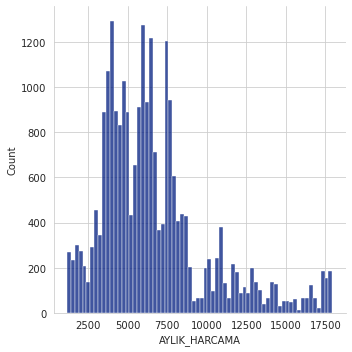

In [53]:
sns.displot(model_data['AYLIK_HARCAMA'])

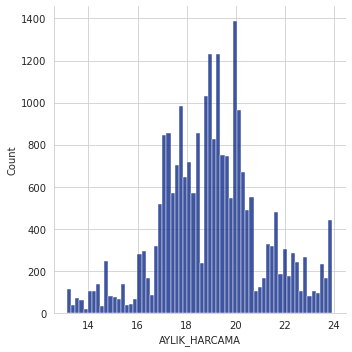

In [54]:
sns.displot(copy_data["AYLIK_HARCAMA"])

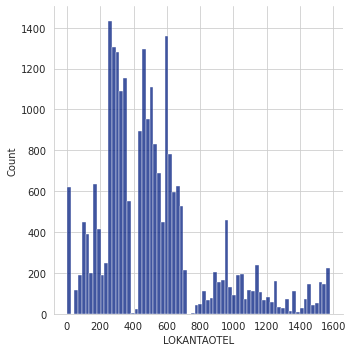

In [55]:
sns.displot(model_data["LOKANTAOTEL"])

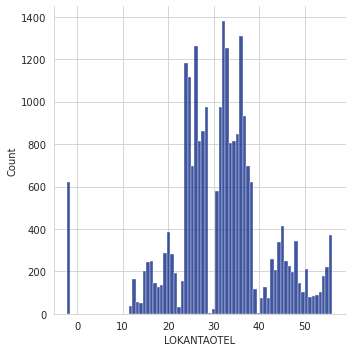

In [56]:
sns.displot(copy_data["LOKANTAOTEL"])

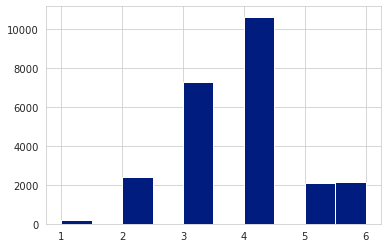

In [57]:
model_data.SES.hist()

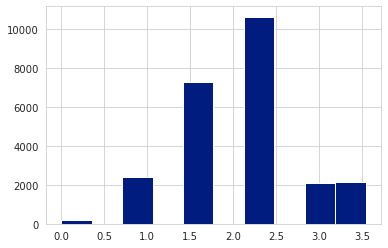

In [58]:
copy_data.SES.hist()

#### Scaling Part

In [59]:
scale_df = copy_data.copy()

In [60]:
scale_df = scale_data(scale_df)

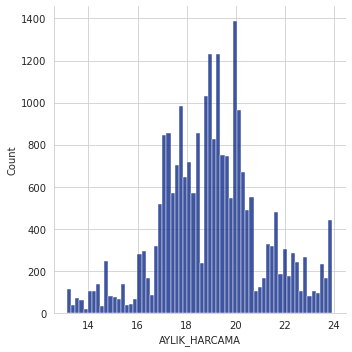

In [61]:
sns.displot(copy_data['AYLIK_HARCAMA'])

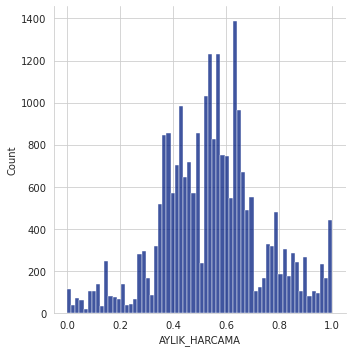

In [62]:
sns.displot(scale_df["AYLIK_HARCAMA"])

# Model 

In [63]:
scale_df.isna().all().all()

False

### K-Means

In [64]:
km_model = KMeans(n_clusters=2, random_state=42, max_iter=1000000, init='k-means++')
km_model.fit(scale_df)
km_preds = km_model.predict(scale_df)

In [65]:
final_df = prep_data.copy()

In [66]:
final_df["k_means_preds"] = km_preds

In [67]:
final_df

,outlet_number,outlet_name,GEOGPOINT,IDARIID,MAIN_CHANNEL,SES,YAS_CLUSTER,ILADI,ILCEADI,HANE_BUYUKLUGU,...,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE,k_means_preds
0,9533320,CICEK TEKEL,POINT(28.96875466 41.0172719600001),33796,TRADITIONAL RETAIL,C1,SIFIR,İstanbul,Fatih,1.363636,...,23.660,78.710,0.0,146.406,39.050,0.000,0.000,102.482,30.260,0
1,9653108,SEVENLER MARKET,POINT(28.9624869078397 41.020159595646),33799,TRADITIONAL RETAIL,D,SIFIR,İstanbul,Fatih,1.195455,...,20.280,29.231,0.0,120.178,31.249,15.956,4.228,2.113,41.863,1
2,9333727,HAKKI INCESU GAZETE BAYII,POINT(28.9637708 41.01996087),33799,TRADITIONAL RETAIL,D,SIFIR,İstanbul,Fatih,1.195455,...,22.815,302.225,0.0,47.083,50.333,46.811,1.057,13.529,15.513,0
3,10729828,BIZIM BAKKAL,POINT(28.96242579 41.02022647),33799,TRADITIONAL RETAIL,D,SIFIR,İstanbul,Fatih,1.195455,...,0.000,14.791,0.0,331.887,28.372,0.000,17.969,14.580,23.181,1
4,8941233,OYLUM TEKEL,POINT(28.9609833900001 41.02061902),33799,TRADITIONAL RETAIL,D,SIFIR,İstanbul,Fatih,1.195455,...,0.000,10.565,0.0,15.320,0.000,0.000,0.000,0.000,0.845,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24706,9552837,NURAL EKMEK,POINT(28.0642712675035 41.2439635349438),34096,TRADITIONAL RETAIL,D,OLD,İstanbul,Silivri,1.234416,...,3.380,44.902,0.0,60.887,11.812,0.000,0.000,5.071,9.108,1
24707,9057957,ENIS BUFE,POINT(28.06332231 41.23700267),34096,TRADITIONAL RETAIL,D,OLD,İstanbul,Silivri,1.234416,...,2.535,292.143,0.0,217.743,28.271,0.000,2.114,23.244,20.096,1
24708,9377687,GUNDOGDU MARKET,POINT(28.0599458701909 41.2357935681939),34096,TRADITIONAL RETAIL,D,OLD,İstanbul,Silivri,1.234416,...,0.000,31.695,0.0,155.479,4.395,0.000,0.000,8.029,22.971,1
24709,9516804,GOKAY MARKET,POINT(28.0643425136805 41.2430779868737),34096,TRADITIONAL RETAIL,D,OLD,İstanbul,Silivri,1.234416,...,0.000,4.226,0.0,58.162,5.749,0.000,0.000,15.213,7.524,1


#### Real Values vs Predictions

In [68]:
# Real Values
ist_data.head(3)

,outlet_number,high_traffic,outlet_name,GEOGPOINT,IDARIID,MAIN_CHANNEL,SES,YAS_CLUSTER,ILADI,ILCEADI,...,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
0,9422535,0,SAMPIYON TEKEL,POINT(29.08295795 40.96606672),33849.0,TRADITIONAL RETAIL,A,OLD,İstanbul,Kadıköy,...,0.000,0.845,16.904,0.0,26.544,7.987,2.557,3.171,57.690,18.639
1,9109019,0,FLAMINGO TEKEL,POINT(29.0819544 40.96638027),33849.0,TRADITIONAL RETAIL,A,OLD,İstanbul,Kadıköy,...,0.528,7.605,223.259,0.0,33.642,51.174,10.978,11.627,237.728,19.525
2,9489908,0,FICI TEKEL,POINT(29.0773806720972 40.9648437285796),33849.0,TRADITIONAL RETAIL,A,OLD,İstanbul,Kadıköy,...,0.000,0.000,60.222,0.0,31.086,4.182,0.000,4.228,33.813,21.511


In [69]:
comparison_df = pd.merge(ist_data, final_df, on='outlet_number')

In [70]:
conf_df = comparison_df[["high_traffic","k_means_preds"]]
conf_df

,high_traffic,k_means_preds
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
60,1,0
61,1,0
62,1,0
63,1,0


In [71]:
len(conf_df.query("high_traffic == 1 & k_means_preds == 1")) 

0

In [72]:
len(conf_df.query("k_means_preds == 0")) 

46

In [73]:
TP = len(conf_df.query("high_traffic == 1 & k_means_preds == 1")) 
FP = len(conf_df.query("high_traffic == 1 & k_means_preds == 0"))
FN = len(conf_df.query("high_traffic == 0 & k_means_preds == 1"))
TN = len(conf_df.query("high_traffic == 0 & k_means_preds == 0"))

In [74]:
print("TP is:", TP)
print("FP is:", FP)
print("FN is:", FN)
print("TN is:", TN)

TP is: 0
FP is: 40
FN is: 19
TN is: 6


### DBSCAN

In [75]:
from sklearn.neighbors import NearestNeighbors

n = NearestNeighbors(n_neighbors=120)
neighbors_fit = n.fit(scale_df)

In [ ]:
distances, indices = neighbors_fit.kneighbors(scale_df)

In [77]:
distance = np.sort(distances, axis=0)
distance = distance[:,1]

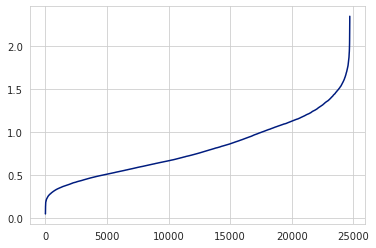

In [78]:
plt.plot(distance)

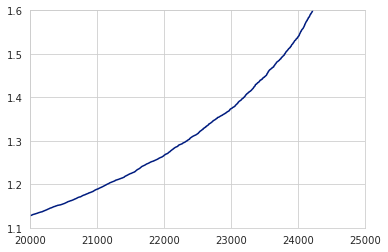

In [79]:
plt.axis([20000, 25000, 1.1, 1.6])
plt.plot(distance)

In [80]:
# Compute DBSCAN
db_model = DBSCAN(eps=0.06, min_samples=120)

In [81]:
db_preds = db_model.fit(scale_df)

In [82]:
np.unique(db_preds.labels_)

array([-1])

In [83]:
y_predicted.labels_

NameError: name 'y_predicted' is not defined

### Hierarchical Clustering

In [331]:
scale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24711 entries, 0 to 24710
Data columns (total 58 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SES                              24711 non-null  float64
 1   SEHIRLESME_INDEKSI               24711 non-null  float64
 2   YAYA_TRAFIGI                     24711 non-null  float64
 3   AYLIK_HARCAMA                    24711 non-null  float64
 4   GIDAVEICECEK                     24711 non-null  float64
 5   ALKOLTUTUN                       24711 non-null  float64
 6   EGLENCEKULTUR                    24711 non-null  float64
 7   LOKANTAOTEL                      24711 non-null  float64
 8   GIDAVEICECEK_ORAN                24711 non-null  float64
 9   ALKOLTUTUN_ORAN                  24711 non-null  float64
 10  EGLENCEKULTUR_ORAN               24711 non-null  float64
 11  LOKANTAOTEL_ORAN                 24711 non-null  float64
 12  ISYERI_YOGUNLUGU_S

In [101]:
from sklearn.cluster import AgglomerativeClustering

hrc_model = AgglomerativeClustering(n_clusters=2, linkage='ward', affinity='euclidean')
hrc_preds = hrc_model.fit_predict(scale_df)

In [102]:
final_df["hrc_preds"] = hrc_preds

In [103]:
final_df["hrc_preds"].unique()

array([0, 1])

In [154]:
final_df['hrc_preds'].value_counts()

0    15794
1     8917
Name: hrc_preds, dtype: int64

In [113]:
final_df.head()

,outlet_number,outlet_name,GEOGPOINT,IDARIID,MAIN_CHANNEL,SES,YAS_CLUSTER,ILADI,ILCEADI,HANE_BUYUKLUGU,...,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE,k_means_preds,hrc_preds
0,9533320,CICEK TEKEL,POINT(28.96875466 41.0172719600001),33796,TRADITIONAL RETAIL,C1,SIFIR,İstanbul,Fatih,1.363636,...,78.710,0.0,146.406,39.050,0.000,0.000,102.482,30.260,0,0
1,9653108,SEVENLER MARKET,POINT(28.9624869078397 41.020159595646),33799,TRADITIONAL RETAIL,D,SIFIR,İstanbul,Fatih,1.195455,...,29.231,0.0,120.178,31.249,15.956,4.228,2.113,41.863,1,0
2,9333727,HAKKI INCESU GAZETE BAYII,POINT(28.9637708 41.01996087),33799,TRADITIONAL RETAIL,D,SIFIR,İstanbul,Fatih,1.195455,...,302.225,0.0,47.083,50.333,46.811,1.057,13.529,15.513,0,0
3,10729828,BIZIM BAKKAL,POINT(28.96242579 41.02022647),33799,TRADITIONAL RETAIL,D,SIFIR,İstanbul,Fatih,1.195455,...,14.791,0.0,331.887,28.372,0.000,17.969,14.580,23.181,1,0
4,8941233,OYLUM TEKEL,POINT(28.9609833900001 41.02061902),33799,TRADITIONAL RETAIL,D,SIFIR,İstanbul,Fatih,1.195455,...,10.565,0.0,15.320,0.000,0.000,0.000,0.000,0.845,1,0


In [118]:
comparison_df2 = pd.merge(ist_data, final_df, on='outlet_number')

In [119]:
conf_df2 = comparison_df2[["high_traffic","hrc_preds"]]
conf_df2

,high_traffic,hrc_preds
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
60,1,1
61,1,1
62,1,1
63,1,1


In [120]:
TP_ = len(conf_df2.query("high_traffic == 1 & hrc_preds == 1")) 
FP_ = len(conf_df2.query("high_traffic == 1 & hrc_preds == 0"))
FN_ = len(conf_df2.query("high_traffic == 0 & hrc_preds == 1"))
TN_ = len(conf_df2.query("high_traffic == 0 & hrc_preds == 0"))

In [347]:
print("TP is:", TP_)
print("FP is:", FP_)
print("FN is:", FN_)
print("TN is:", TN_)

TP is: 36
FP is: 4
FN is: 7
TN is: 18


In [352]:
print("Accuracy is: %", (TP_+TN_)/(TP_+TN_+FN_+FP_)*100)

Accuracy is: % 83.07692307692308


<img src="image.png" width=300 height=300 />


### -> % 83 accuracy

In [128]:
# extract coordinates
final_df["x"] = final_df["GEOGPOINT"].apply(lambda x: x.split(")")[0].split("POINT(")[1].split(" ")[1])
final_df["y"] = final_df["GEOGPOINT"].apply(lambda x: x.split(")")[0].split("POINT(")[1].split(" ")[0])

In [130]:
final_df["y"] = pd.to_numeric(final_df["y"], downcast="float")
final_df["x"] = pd.to_numeric(final_df["x"], downcast="float")

## Decision Points

In [201]:
# decision tree için kullanılacak bu data; içinde scale edilmiş değerler yanında hier. clustering prediction'larını da içerir.
decision_df = scale_df.copy()

In [202]:
decision_df['hrc_preds'] = hrc_preds

In [209]:
from sklearn.model_selection import train_test_split

x = decision_df.drop('hrc_preds', axis=1)
y = decision_df['hrc_preds']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=41)
    
dc = DecisionTreeClassifier(criterion="entropy", random_state=42) 
dc.fit(x_train, y_train)
dc_pred = dc.predict(x_test)

d_text = tree.export_text(dc)
print(d_text)

|--- feature_24 <= 0.49
|   |--- feature_38 <= 0.50
|   |   |--- feature_29 <= 0.50
|   |   |   |--- feature_6 <= 0.76
|   |   |   |   |--- feature_30 <= 0.50
|   |   |   |   |   |--- feature_28 <= 0.50
|   |   |   |   |   |   |--- feature_16 <= 0.50
|   |   |   |   |   |   |   |--- feature_20 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_18 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_47 <= 1.00
|   |   |   |   |   |   |   |   |   |   |--- feature_39 <= 0.80
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- feature_39 >  0.80
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |--- feature_47 >  1.00
|   |   |   |   |   |   |   |   |   |   |--- feature_44 <= 0.91
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- feature_44 >  0.91
|   |   |   |   |   |   |   |   | 

In [211]:
from sklearn import metrics
metrics.accuracy_score(y_test, dc_pred)

0.9356223175965666

In [212]:
dc.feature_importances_

array([0.        , 0.0145586 , 0.00696963, 0.00291013, 0.00554109,
       0.00617328, 0.05463013, 0.03012685, 0.00044087, 0.00136229,
       0.00859385, 0.00163562, 0.00291468, 0.00598338, 0.00367384,
       0.00790766, 0.00976794, 0.00482612, 0.00786491, 0.        ,
       0.00863852, 0.00834435, 0.00849849, 0.02601155, 0.20169756,
       0.01151439, 0.01870186, 0.02055962, 0.02044405, 0.13350503,
       0.00793317, 0.        , 0.00429737, 0.        , 0.        ,
       0.01168694, 0.00818278, 0.00247703, 0.18689983, 0.01347862,
       0.0005815 , 0.00392099, 0.0066127 , 0.00548307, 0.03947308,
       0.0050944 , 0.00889007, 0.00456   , 0.0063407 , 0.00909094,
       0.00169417, 0.00548904, 0.00898451, 0.00299219, 0.0116231 ,
       0.00389193, 0.00652559, 0.        ])

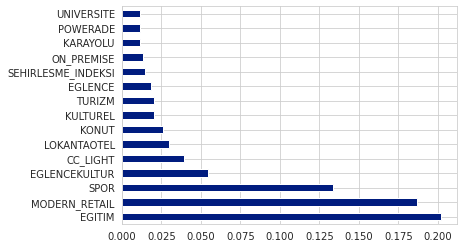

In [213]:
pd.Series(dc.feature_importances_, index=x_train.columns).nlargest(15).plot(kind='barh')

In [225]:
analysis_df = final_df.drop([ 
"MAIN_CHANNEL"                                             
,"YAS_CLUSTER"                    
,"ILADI"                          
,"ILCEADI"  
,"GEOGPOINT"
,"IDARIID"
,"HANE_BUYUKLUGU"
,"k_means_preds"
,"x","y"
],axis=1)

In [226]:
final_high = analysis_df.query("hrc_preds == 1")
final_low = analysis_df.query("hrc_preds == 0") 

In [227]:
final_high.describe()

,outlet_number,GUNDUZ_NUFUS,GECE_NUFUS,ZENGINLIK_INDEKSI,SEHIRLESME_INDEKSI,YAYA_TRAFIGI,AYLIK_HARCAMA,GIDAVEICECEK,ALKOLTUTUN,EGLENCEKULTUR,...,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE,hrc_preds
count,8.917000e+03,8917.000000,8917.000000,8917.000000,8917.000000,8917.000000,8917.000000,8917.000000,8917.000000,8917.000000,...,8917.000000,8917.000000,8917.000000,8917.000000,8917.000000,8917.000000,8917.000000,8917.000000,8917.000000,8917.0
mean,8.810957e+06,36534.376360,29354.636313,4.003204,9.693872,9.369612,7918.688460,1139.074688,254.883120,303.051101,...,7.589208,83.739182,0.021604,193.723720,35.050235,5.653801,3.039779,24.336796,29.688407,1.0
std,2.232438e+06,25244.753162,18840.964459,2.321252,0.692247,0.806519,4004.441082,376.977791,76.787452,213.785197,...,19.475134,245.735317,0.266417,351.359433,49.011784,15.287017,6.236035,38.109215,48.535335,0.0
min,6.018800e+04,828.000000,15.000000,0.295000,1.000673,6.034572,1172.000000,264.471000,56.256000,21.096000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,9.060599e+06,18782.000000,16024.000000,2.253000,9.977942,8.999386,4871.000000,857.296000,189.969000,146.130000,...,0.000000,4.226000,0.000000,52.242000,3.676000,0.000000,0.000000,2.113000,7.016000,1.0
50%,9.398610e+06,31875.000000,26181.000000,3.336000,9.999828,9.996058,6867.000000,1123.576000,256.243000,219.744000,...,0.845000,16.904000,0.000000,112.679000,17.683000,0.000000,0.000000,11.832000,19.439000,1.0
75%,9.612905e+06,48669.000000,37755.000000,5.239000,10.000000,9.999882,10190.000000,1340.342000,309.212000,468.740000,...,6.760000,65.503000,0.000000,224.870000,46.906000,5.864000,4.228000,31.695000,38.245000,1.0
max,2.004005e+07,291434.000000,101668.000000,10.000000,10.000000,10.000000,17944.000000,2063.560000,412.712000,825.424000,...,461.370000,10305.681000,10.117000,11201.825000,556.307000,486.253000,140.581000,1148.479000,2637.824000,1.0


In [228]:
final_low.describe()

,outlet_number,GUNDUZ_NUFUS,GECE_NUFUS,ZENGINLIK_INDEKSI,SEHIRLESME_INDEKSI,YAYA_TRAFIGI,AYLIK_HARCAMA,GIDAVEICECEK,ALKOLTUTUN,EGLENCEKULTUR,...,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE,hrc_preds
count,1.579400e+04,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,...,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,15794.000000,15794.0
mean,8.838621e+06,29475.165506,29562.164430,2.919780,9.394397,9.057796,5997.079271,914.884176,211.171926,194.703686,...,8.164056,71.767437,0.007210,247.625820,35.974237,5.451618,1.979416,17.670786,28.548490,0.0
std,2.036680e+06,25368.028897,19981.144398,1.639352,1.076225,0.975455,2920.980251,372.146388,87.260991,146.425324,...,21.266531,209.596162,0.133544,379.844013,49.885086,33.003469,4.743921,27.665618,42.196495,0.0
min,6.000500e+04,0.000000,0.000000,0.104000,0.000000,0.000000,1144.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,9.071366e+06,13141.500000,15536.000000,1.783745,9.000290,8.002764,4013.000000,676.192000,150.210000,114.517500,...,0.000000,4.226000,0.000000,79.171250,3.788500,0.000000,0.000000,0.845000,6.339000,0.0
50%,9.406376e+06,24593.000000,26168.000000,2.676000,9.998879,9.000855,5661.000000,919.502000,223.450000,176.128000,...,0.845000,16.904000,0.000000,164.069000,18.385000,0.000000,0.000000,8.452000,18.429000,0.0
75%,9.612865e+06,39789.000000,39411.000000,3.664000,9.999998,9.999617,7409.000000,1189.040000,277.119000,236.032000,...,7.605000,55.644000,0.000000,299.053000,48.392750,4.228000,2.114000,23.243000,37.513250,0.0
max,2.003936e+07,291434.000000,101668.000000,10.000000,10.000000,10.000000,17944.000000,2063.560000,412.712000,825.424000,...,881.335000,6952.624000,8.364000,11296.120000,1760.109000,3533.103000,121.555000,620.377000,1649.420000,0.0


#### High Traffic

In [251]:
print("High Traffic çıkan toplam outlet sayısı : ", final_high.outlet_number.nunique(), "\n")

print("High Traffic'in ortalama aylık harcaması: ", final_high['AYLIK_HARCAMA'].mean(), "\n") 

print("High Traffic'in ortalama yaya trafiği: ", final_high['YAYA_TRAFIGI'].mean(), "\n") 

print("High Traffic'in A,B,C1 kategorisindeki toplam outlet sayısı oranı: ", "%",final_high.query("SES == 'A' or SES == 'B' or SES == 'C1'").outlet_number.nunique()/len(final_high.SES) * 100  , "\n")

print("High Traffic'in ortalama Gündüz Nufusu sayısı: ", final_high.GUNDUZ_NUFUS.mean(), "\n")

print("High Traffic'in ortalama Gece Nufusu sayısı: ", final_high.GECE_NUFUS.mean(), "\n")

print("High Traffic'in ortalama Eğitim birimi sayısı: ", final_high.EGITIM.mean())
print("High Traffic'in minimum Eğitim birimi sayısı: ", final_high.EGITIM.min())
print("High Traffic'in maximum Eğitim birimi sayısı: ", final_high.EGITIM.max(), "\n")

print("High Traffic'in ortalama Modern Retail birimi sayısı: ", final_high.MODERN_RETAIL.mean(), "\n")

print("High Traffic'in ortalama Spor birimi sayısı: ", final_high.SPOR.mean(), "\n")

High Traffic çıkan toplam outlet sayısı :  8917 

High Traffic'in ortalama aylık harcaması:  7918.688460244477 

High Traffic'in ortalama yaya trafiği:  9.369612072241038 

High Traffic'in A,B,C1 kategorisindeki toplam outlet sayısı oranı:  % 70.89828417629246 

High Traffic'in ortalama Gündüz Nufusu sayısı:  36534.37635976225 

High Traffic'in ortalama Gece Nufusu sayısı:  29354.63631266121 

High Traffic'in ortalama Eğitim birimi sayısı:  1.2791297521587979
High Traffic'in minimum Eğitim birimi sayısı:  0.0
High Traffic'in maximum Eğitim birimi sayısı:  36.0 

High Traffic'in ortalama Modern Retail birimi sayısı:  0.4531793203992374 

High Traffic'in ortalama Spor birimi sayısı:  0.3993495570259056 



<br>

#### Non-high Traffic

In [252]:
print("Non-high Traffic çıkan toplam outlet sayısı : ", final_low.outlet_number.nunique(), "\n")

print("Non-high Traffic'in ortalama aylık harcaması: ", final_low['AYLIK_HARCAMA'].mean(), "\n") 

print("Non-high Traffic'in ortalama yaya trafiği: ", final_low['YAYA_TRAFIGI'].mean(), "\n") 

print("Non-high Traffic'in A,B,C1 kategorisindeki toplam outlet sayısı oranı: ", "%", final_low.query("SES == 'A' or SES == 'B' or SES == 'C1'").outlet_number.nunique()/len(final_low.SES) * 100  , "\n")

print("Non-high Traffic'in ortalama Gündüz Nufusu sayısı: ", final_low.GUNDUZ_NUFUS.mean(), "\n")

print("Non-high Traffic'in ortalama Gece Nufusu sayısı: ", final_low.GECE_NUFUS.mean(), "\n")

print("Non-high'in ortalama Eğitim birimi sayısı: ", final_low.EGITIM.mean())
print("Non-high'in minimum Eğitim birimi sayısı: ", final_low.EGITIM.min())
print("Non-high'in maximum Eğitim birimi sayısı: ", final_low.EGITIM.max(), "\n")

print("Non-high'in ortalama Modern Retail birimi sayısı: ", final_low.MODERN_RETAIL.mean(), "\n")

print("Non-high'in ortalama Spor birimi sayısı: ", final_low.SPOR.mean(), "\n")

Non-high Traffic çıkan toplam outlet sayısı :  15794 

Non-high Traffic'in ortalama aylık harcaması:  5997.079270609092 

Non-high Traffic'in ortalama yaya trafiği:  9.057795697775942 

Non-high Traffic'in A,B,C1 kategorisindeki toplam outlet sayısı oranı:  % 54.03950867418007 

Non-high Traffic'in ortalama Gündüz Nufusu sayısı:  29475.16550588831 

Non-high Traffic'in ortalama Gece Nufusu sayısı:  29562.164429530203 

Non-high'in ortalama Eğitim birimi sayısı:  0.1939344054704318
Non-high'in minimum Eğitim birimi sayısı:  0.0
Non-high'in maximum Eğitim birimi sayısı:  29.0 

Non-high'in ortalama Modern Retail birimi sayısı:  0.041344814486513864 

Non-high'in ortalama Spor birimi sayısı:  0.04748638723565911 



### Graph

In [284]:
column_names = ["BURN"
,"CAPPY"                            
,"CC_LIGHT"                         
,"CC_NO_SUGER"                      
,"COCACOLA"                         
,"COCACOLA_ENERGY"                  
,"DAMLA_MINERA"                     
,"DAMLA_WATER"                      
,"EXOTIC"                           
,"FANTA"                            
,"FUSETEA"                          
,"MONSTER"                          
,"POWERADE"                         
,"SCHWEPPES"]                      

In [316]:
final_high_brands = final_high[column_names].reset_index(drop=True)

In [317]:
high_brands_sum = pd.DataFrame(final_high_brands.sum()).reset_index()

In [318]:
high_brands_sum.rename({"index": "brand", 0: "values",} ,axis=1,inplace=True)

In [319]:
high_brands_sum

,brand,values
0,BURN,43706.287
1,CAPPY,960757.528
2,CC_LIGHT,52387.533
3,CC_NO_SUGER,481466.955
4,COCACOLA,6150639.695
5,COCACOLA_ENERGY,924.528
6,DAMLA_MINERA,67672.968
7,DAMLA_WATER,746702.289
8,EXOTIC,192.644
9,FANTA,1727434.411


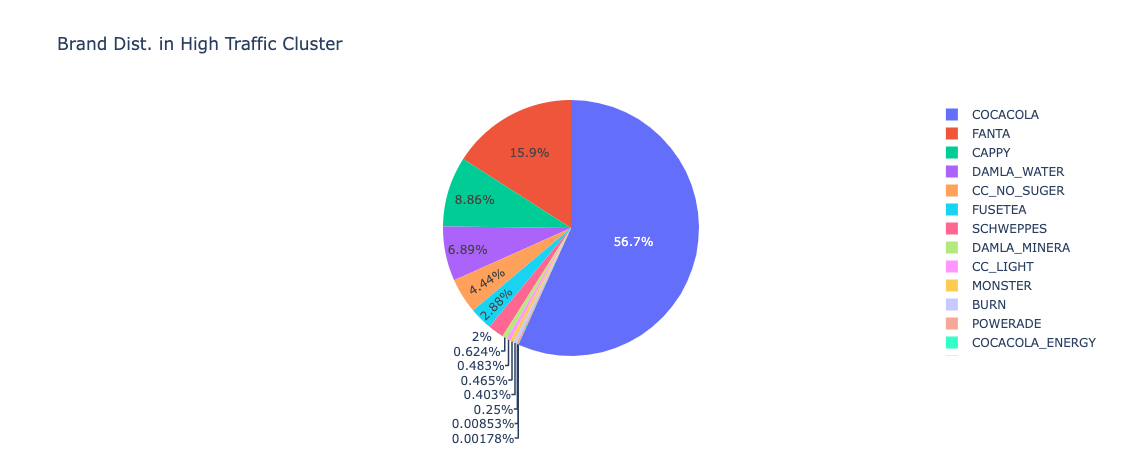

In [321]:
fig = px.pie(high_brands_sum, values='values', names="brand", title='Brand Dist. in High Traffic Cluster')
fig.show()

In [344]:
final_high.groupby('SES')['outlet_number'].sum().sort_values()

SES
E       123736835
D      3589116553
B      9509668741
A     11944004440
C2    19667146941
C1    33733628947
Name: outlet_number, dtype: int64

In [322]:
non_high_brands = final_low[column_names].reset_index(drop=True)

In [323]:
non_brands_sum = pd.DataFrame(non_high_brands.sum()).reset_index()

In [324]:
non_brands_sum.rename({"index": "brand", 0: "values",} ,axis=1,inplace=True)

In [329]:
non_brands_sum.query("brand == 'CC_LIGHT'")

,brand,values
2,CC_LIGHT,44099.696


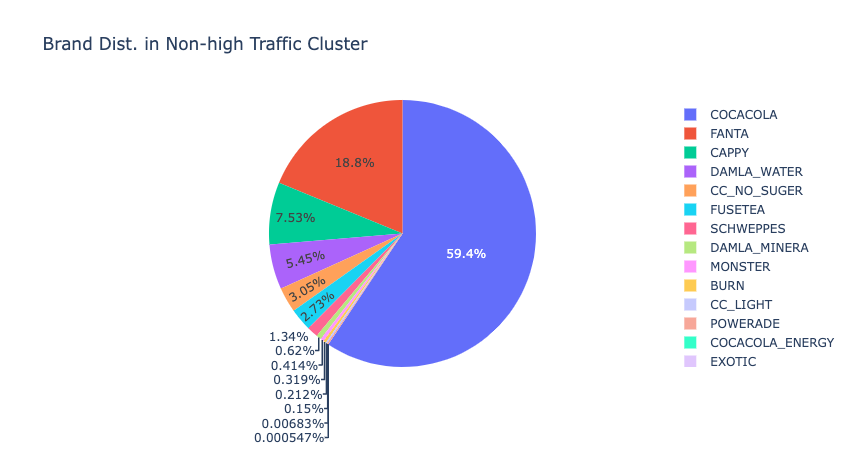

In [326]:
fig = px.pie(non_brands_sum, values='values', names="brand", title='Brand Dist. in Non-high Traffic Cluster')
fig.show()

In [345]:
final_low.groupby('SES')['outlet_number'].sum().sort_values()

SES
E      1583098968
A      6165379175
B      8677640840
D     17421944509
C2    45572481815
C1    60176632038
Name: outlet_number, dtype: int64

----

## Score Based

In [85]:
high_df = ist_data.query("high_traffic==1")
non_df = ist_data.query("high_traffic==0")

In [88]:
high_df.describe()

,outlet_number,high_traffic,IDARIID,HANE_BUYUKLUGU,GUNDUZ_NUFUS,GECE_NUFUS,ZENGINLIK_INDEKSI,SEHIRLESME_INDEKSI,YAYA_TRAFIGI,AYLIK_HARCAMA,...,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
count,4.000000e+01,40.0,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,8.378280e+06,1.0,33728.825000,1.496225,40495.250000,13260.875000,8.787191,9.622704,9.470676,15883.000000,...,0.316800,10.332150,348.503825,0.481225,74.316050,40.271850,15.139550,10.966375,77.004225,41.581750
std,4.405791e+06,0.0,227.645911,0.208615,29615.149887,9779.387798,1.629684,0.809377,0.846209,2887.299572,...,1.088007,13.081595,522.387021,1.420399,64.724298,49.297017,16.893406,12.227902,74.615718,38.202166
min,6.466450e+05,1.0,33479.000000,0.937099,0.000000,730.000000,3.485561,7.000259,7.000243,6481.000000,...,0.000000,0.000000,0.000000,0.000000,0.845000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.501647e+06,1.0,33493.000000,1.407596,16155.250000,4442.500000,8.773112,9.985373,8.999920,15462.000000,...,0.000000,0.845000,12.149750,0.000000,22.690250,9.965000,2.787250,3.171000,26.417250,12.900500
50%,9.457782e+06,1.0,33832.500000,1.452195,34818.500000,10717.000000,9.251500,9.999776,9.998257,16760.500000,...,0.000000,3.802500,74.046500,0.000000,61.107500,24.115500,7.228000,8.456000,47.016500,28.101500
75%,9.634731e+06,1.0,33834.000000,1.634630,58586.250000,22763.000000,9.967000,10.000000,10.000000,17892.000000,...,0.000000,16.688750,459.104250,0.000000,103.571750,56.757000,27.538250,12.684000,130.013000,65.607750
max,2.003703e+07,1.0,34146.000000,1.882687,88924.000000,33789.000000,10.000000,10.000000,10.000000,17943.000000,...,6.336000,48.165000,1883.574000,6.248000,320.757000,209.229000,68.394000,54.964000,312.765000,140.710000


In [91]:
non_df.describe()

,outlet_number,high_traffic,IDARIID,HANE_BUYUKLUGU,GUNDUZ_NUFUS,GECE_NUFUS,ZENGINLIK_INDEKSI,SEHIRLESME_INDEKSI,YAYA_TRAFIGI,AYLIK_HARCAMA,...,COCACOLA_ENERGY,DAMLA_MINERA,DAMLA_WATER,EXOTIC,FANTA,FUSETEA,MONSTER,POWERADE,SCHWEPPES,SPRITE
count,2.500000e+01,25.0,25.0000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.0000,...,25.000000,25.000000,25.000000,25.0,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000
mean,8.501300e+06,0.0,57111.1600,2.066765,56603.440000,20912.560000,4.182680,9.762014,9.132100,8159.9200,...,0.126720,12.539800,97.764400,0.0,167.956880,39.313520,5.31716,2.283120,29.067920,21.153000
std,2.815190e+06,0.0,48682.4927,0.630885,73646.108865,14453.560245,3.056229,0.427171,0.952183,5213.3481,...,0.276045,20.549142,134.529281,0.0,199.453242,56.226363,15.78751,3.474728,48.176564,22.610693
min,1.102130e+05,0.0,33663.0000,1.041667,13108.000000,75.000000,1.178000,8.914393,7.997755,2760.0000,...,0.000000,0.000000,0.000000,0.0,16.313000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,9.248670e+06,0.0,33849.0000,1.559234,19618.000000,7546.000000,2.372000,9.977842,8.001627,5091.0000,...,0.000000,0.000000,16.904000,0.0,45.478000,6.317000,0.00000,0.000000,0.000000,2.113000
50%,9.453197e+06,0.0,34168.0000,2.181424,34085.000000,20858.000000,2.845000,9.997078,9.958329,5973.0000,...,0.000000,0.845000,60.222000,0.0,144.765000,17.306000,0.00000,0.000000,16.907000,18.639000
75%,9.590875e+06,0.0,34275.0000,2.635838,58456.000000,26560.000000,5.145000,10.000000,10.000000,10032.0000,...,0.000000,11.830000,120.449000,0.0,195.007000,51.174000,2.11400,4.228000,40.148000,27.279000
max,1.024028e+07,0.0,171023.0000,3.168547,291434.000000,64030.000000,9.912000,10.000000,10.000000,17805.0000,...,1.056000,61.685000,589.919000,0.0,966.224000,213.892000,75.65300,11.627000,237.728000,89.962000


In [ ]:
stophere

----

In [351]:
# bigquery'e tabloyu ekleme
# Database Connection
from google.cloud import bigquery, bigquery_storage_v1beta1

client = bigquery.Client()

table_id = "coca-cola-data-lake.predictive_order.high_traffic_clusters_istanbul" 

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("outlet_name", bigquery.enums.SqlTypeNames.STRING),
    ],  write_disposition="WRITE_TRUNCATE"
)

job = client.load_table_from_dataframe(final_df, table_id, job_config=job_config)  
job.result()  

table = client.get_table(table_id)  
print("Loaded {} rows and {} columns to {}".format(table.num_rows, len(table.schema), table_id))

Loaded 24711 rows and 75 columns to coca-cola-data-lake.predictive_order.high_traffic_clusters_istanbul


#### Save as CSV

In [358]:
csv_df = final_df.copy()

In [359]:
csv_df = csv_df.rename({"hrc_preds": "high_traffic"}, axis=1)
csv_df = csv_df.drop("k_means_preds", axis=1)

In [369]:
csv_df.to_csv("istanbul_high_traffic.csv")

### Save Model

In [370]:
import pickle

# It is important to use binary access
with open('hrc_model.pickle', 'wb') as f:
    pickle.dump(hrc_model, f)